# Detectia Indatiilor
Autor: Morariu Tudor

## Pas 1: Import-uri

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:88: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


ValueError: Token is required (write-access action) but no token found. You need to provide a token or be logged in to Hugging Face with `huggingface-cli login` or `huggingface_hub.login`. See https://huggingface.co/settings/tokens.

In [10]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
from PIL import Image
import cv2
import glob
import copy
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset,DataLoader,random_split,Subset
import torchvision
import torchvision.transforms.functional as tf
from torchvision.models.segmentation import deeplabv3_resnet50
from torchvision.models.segmentation import DeepLabV3_ResNet50_Weights
import albumentations as alb


## Pas 2: Citirea datelor

In [11]:
images_path = "/content/drive/MyDrive/Colab Notebooks/Image Segmentation/Image"
labels_path ="/content/drive/MyDrive/Colab Notebooks/Image Segmentation/Mask"

# Normalizam valorile intre [0, 1]
mean=[0.5, 0.5, 0.5]
std=[0.5, 0.5, 0.5]

### Pas 2.1: Definirea transform-urilor

In [12]:
# Pentru datele de train voi face transformarile:
train_transform=alb.Compose([
                alb.Resize(height=480,width=480),  # Resize imaginea la o dimensiune standard
                alb.Normalize()                    # Normalizam imaginile
                            ],
                            is_check_shapes=False)


test_transform=alb.Compose([
                alb.Resize(height=480,width=480),
                alb.Normalize()
                           ],
                           is_check_shapes=False);

val_transform=alb.Compose([
                alb.Resize(height=480,width=480),
                alb.Normalize()
                           ],
                           is_check_shapes=False);


### Pas 2.2: Definirea dataset-ului custom

In [13]:
class DatasetSegmentareImagini(Dataset):
    def __init__(self, images_dir, labels_dir, transform=None):
        super().__init__()
        self.images_dir = images_dir                  # Setam locatia imaginiilor

        self.image_list = []                          # Declaram o lista cu numele imaginiilor

        for img_name in os.listdir(self.images_dir):
          self.image_list.append(img_name)            # Adaugam in lista numele imaginii


        self.labels_dir = labels_dir                  # Setam locatia label-urilor
        self.transform=transform                      # Setam ce transformari sa faca pe imagni

    def __len__(self):
        return len(self.image_list)                   # Functia specifica pentru metoda len()

    def __getitem__(self,idx):                        # Functia specifica pentru indexare
        image_path = os.path.join(self.images_dir, self.image_list[idx])  # Creez path-ul complet pentru fiecare imagine
        image = Image.open(image_path).convert("RGB")                     # Deschid imaginea cu PIL in format RGB
        image = np.array(image)

        label_path = os.path.join(self.labels_dir, self.image_list[idx][:-4]+".png") # Similar ca mai sus dar cu alta extensie
        label = Image.open(label_path).resize((480, 480))                            # Similar ca mai sus dar cu label-uri

        label = np.array(label)
        label = np.where(label > 128, 1, 0) # Inlocuiesc cu 1 peste tot unde pixel-ul din label este mai mare ca 128

        if self.transform is not None:
            transform = self.transform(image = image, mask = label) # Daca exista un transformer il aplic
            image = transform["image"]    # Salvez imaginile
            label = transform["mask"]    # Salvez label-urile

        label=torch.as_tensor(label,dtype=torch.int64) # Convertim label-ul in tensor
        image=tf.to_tensor(image)                      # Convertesc imaginea in tensor

        return image,label


### Pas 2.3: Train-Test-Validation Split

In [14]:
train_ds = DatasetSegmentareImagini(images_path, labels_path, train_transform); # Incarcam trainset-ul
test_ds = DatasetSegmentareImagini(images_path, labels_path, test_transform);   # Incarcam testset-ul
val_ds = DatasetSegmentareImagini(images_path, labels_path, val_transform);     # Incarcam validationset-ul


#### Train-Test-Validation Split
train_idx, test_idx = random_split(range(len(train_ds)), [0.75,0.25]);
train_ds = Subset(train_ds, train_idx);

train_idx, val_idx = random_split(range(len(train_ds)), [0.90,0.10]);

train_ds = Subset(train_ds, train_idx);
test_ds = Subset(test_ds, test_idx);
val_ds = Subset(val_ds, val_idx);


In [15]:
print(f"Train Dataset: ", len(train_ds), "Validation Dataset: ", len(val_ds), "Test Dataset: ", len(test_ds))

Train Dataset:  197 Validation Dataset:  21 Test Dataset:  72


### Pas 2.4: Definirea Dataload-urilor


In [16]:
train_dl=DataLoader(
    train_ds,       # Dataset-ul din care sa incarce imaginiile
    batch_size=4,   # Dimensiunea fiecarui batch
    shuffle=True,   # Flag care indica daca sa amstece pozele
    num_workers=2,  # Numarul de core-uri care sa incarce pozele
    drop_last=True  # Flag care indica daca sa elimine ultimul batch, deoarece are dimensiune incompleta
    )

test_dl=DataLoader(
    test_ds,
    batch_size=4,
    shuffle=False,
    num_workers=2,
    drop_last=True
    )

val_dl=DataLoader(
    val_ds,
    batch_size=4,
    shuffle=False,
    num_workers=2,
    drop_last=True
    )


## Pas 3: Plot cu cateva exemple din dataset

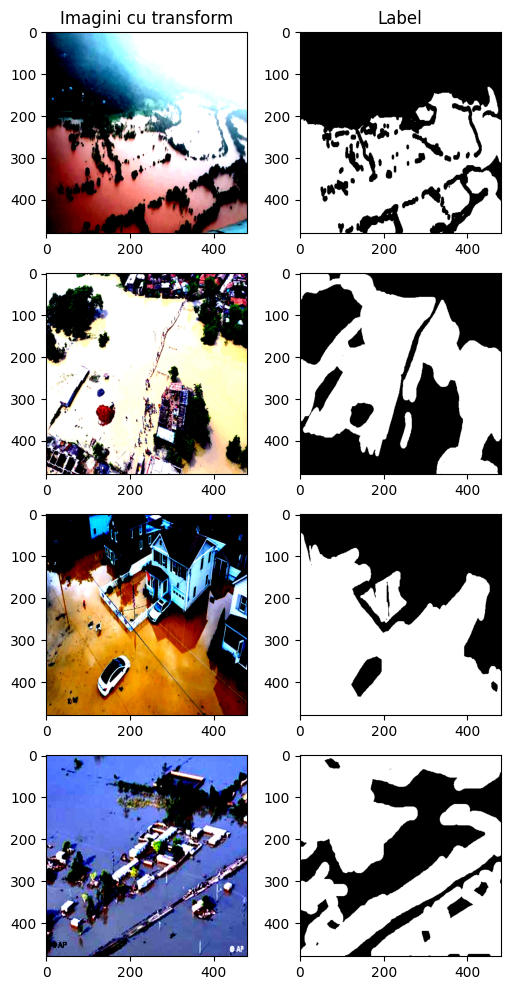

In [17]:
ax = plt.figure(figsize=(6, 12)).subplots(4, 2)


for i in range(4):
    img, label = train_ds[i]

    ax[i, 0].imshow(np.transpose(img.numpy(), (1, 2, 0)));
    ax[i, 1].imshow(label.numpy(), cmap="gray");

ax[0, 0].set_title("Imagini cu transform");
ax[0, 1].set_title("Label");


## Pas 4: Incarcarea Modelului

In [18]:
model=deeplabv3_resnet50(weights=DeepLabV3_ResNet50_Weights.DEFAULT)
model.classifier[4]=nn.Conv2d(256, 2, kernel_size=(1, 1))

device = torch.device("cuda")

model.to(device)

DeepLabV3(
  (backbone): IntermediateLayerGetter(
    (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): Bottleneck(
        (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (downsample): Se

## Pas 5: Pregatire si Training

### Pas 5.1: Definirea parametriilor trainable

Voi opta ca ultimele doua layere sa fie trainable, astfel sa nu modific weight-urile pretrained pe tot modelul.

In [19]:
modulelist=[]
for name,children in model.backbone.named_children():
    modulelist.append(name)

print(modulelist)

['conv1', 'bn1', 'relu', 'maxpool', 'layer1', 'layer2', 'layer3', 'layer4']


In [20]:
# Setam ce layere sunt trainable si care nu

for name,children in model.backbone.named_children():
    if name in ['conv1', 'bn1', 'relu', 'maxpool', 'layer1', 'layer2']:
        for namel,params in children.named_parameters():
            params.requires_grad=False

parameters = []

for param in model.parameters():
  if(param.requires_grad == True):
    parameters.append(param)


### Pas 5.2: Definirea Hiperparametriilor

In [21]:
epochs = 2

loss_fn = nn.CrossEntropyLoss(reduction="mean")
optimizer = optim.Adam(parameters, lr=0.001)

### Pas 5.3: Clasa de Logging

In [22]:
class Metric():
    def __init__(self,predictions,labels,nclasses):
        self.predictions=predictions # Predictiile modelului
        self.labels=labels           # Label-urile corecte
        self.classes=nclasses        # Numarul de clase in care sa imparta pixeli

    def accuracy(self):
        predictions = torch.argmax(self.predictions, dim=1) # Calculez matricea de treshold pentru predicita maxima
        labels = self.labels;
        corect = (labels==predictions).sum().item()          # Numar cate predictii sunt corecte

        total = predictions.numel()                         # Numarul total de elemente
        accuracy = corect/total                             # Calculez acuratetea

        return accuracy


### Pas 5.4: Training

In [23]:
import torch
from torch.utils.tensorboard import SummaryWriter
writer = SummaryWriter() # Definesc Write-ul pentru tensorboard

loss_history={"training_loss":[],
              "training_accuracy":[],
              "validation_loss":[],
              "validation_accuracy":[]}

train_len=len(train_dl)
val_len=len(val_dl)

best_validation_loss=np.inf
best_weights=copy.deepcopy(model.state_dict())

for epoch in range(epochs):

    training_loss = 0.0
    training_accuracy = 0.0
    validation_loss = 0.0
    validation_accuracy = 0.0

    model.train()

    for imgs, labels in train_dl:
        imgs = imgs.to(device)      # Incarcarea imaginilor pe memoria de GPU
        labels = labels.to(device)  # Incarcarea label-urilor pe memoria de GPU

        output = model(imgs)  # Predictia modelului pentru input

        loss = loss_fn(output["out"],labels)      # Calculez loss-ul
        metric = Metric(output["out"], labels, 2) # Pun in obiectul de metrici

        training_loss += loss.item()            # Adaug la training_loss
        training_accuracy += metric.accuracy()  # Adaug la training_accuracy

        optimizer.zero_grad() # Update optimizer-ul
        loss.backward()       # Facem backwards propagation
        optimizer.step()      # Update weight-urile

    for imgs, labels in val_dl:

        imgs = imgs.to(device)      # Incarcarea imaginilor pe memoria de GPU
        labels = labels.to(device)  # Incarcarea label-urilor pe memoria de GPU

        output = model(imgs)  # Predictia modelului pentru input

        loss = loss_fn(output["out"],labels)      # Calculez loss-ul
        metric = Metric(output["out"], labels, 2) # Pun in obiectul de metrici

        validation_loss += loss.item()            # Adaug la validation_loss
        validation_accuracy += metric.accuracy()  # Adaug la validation_accuracy

        ## Nota: Aici nu invoc optimizer-ul pentru ca nu fac training pe validation data

    ## Adaug la dict-ul de log-uri
    loss_history["training_loss"].append(training_loss/train_len)
    loss_history["training_accuracy"].append(training_accuracy/train_len)
    loss_history["validation_loss"].append(validation_loss/val_len)
    loss_history["validation_accuracy"].append(validation_accuracy/val_len)

    print("Epoca ", epoch)
    print("Training Loss Avg: ", training_loss/train_len)
    print("Validation loss Avg: ", validation_loss/val_len)




/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Epoca  0
Training Loss Avg:  0.39667259004651284
Validation loss Avg:  0.29686793088912966
Epoca  1
Training Loss Avg:  0.28258242716594617
Validation loss Avg:  0.25803208649158477


TypeError: 'int' object is not iterable

In [24]:
for i in range(epochs):
  # Adaug log-urile in tensorbloard pentru grafice frumoase
  writer.add_scalar("Loss/train", loss_history["training_loss"][i], i)
  writer.add_scalar("Acc/train", loss_history["training_accuracy"][i], i)
  writer.add_scalar("Loss/Val", loss_history["validation_loss"][i], i)
  writer.add_scalar("Acc/Val", loss_history["validation_accuracy"][i], i)

writer.close()

## Pas 6: Testarea pe cateva exemple

/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


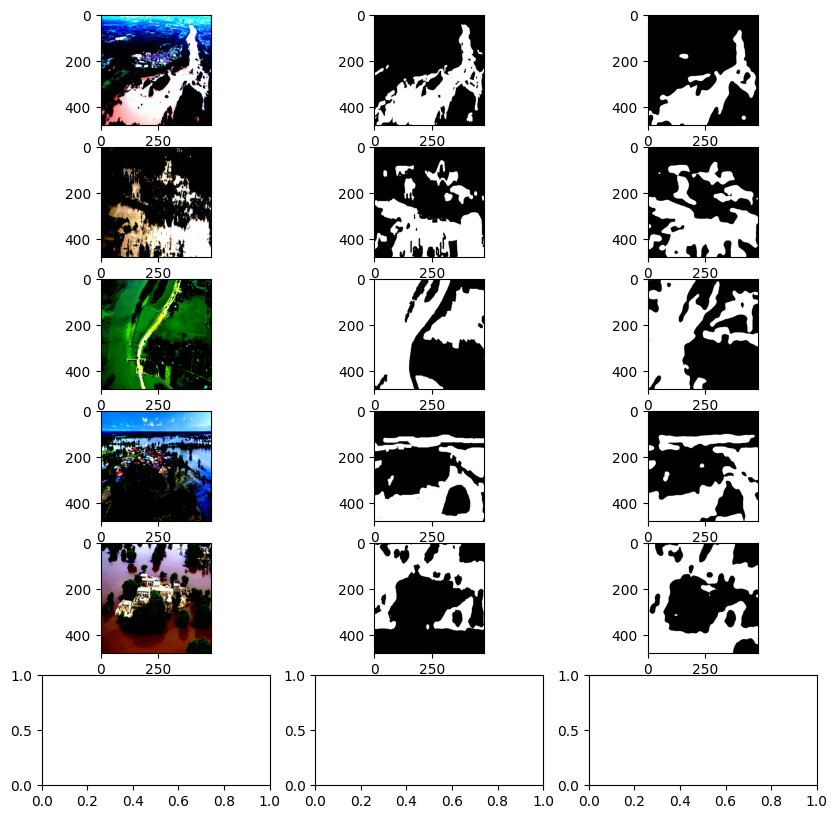

In [25]:
import PIL.Image

model.eval()

ax = plt.figure(figsize=(10, 10)).subplots(6, 3)

it = 0;

for image, mask in val_dl:

  if(it >= 6): break

  image = image.to(device) # Incarc imaginea pe memoria GPU-ului

  prediction = model(image)['out']                     # Iau prezicerea modelului
  prediction_masks = torch.argmax(prediction, dim = 1) # Calculez masca rezultata

  # Plotez imaginile rezultate
  ax[it][0].imshow(image[0].permute(1, 2, 0).cpu().numpy())
  ax[it][1].imshow(mask[0].cpu().numpy(), cmap="gray")
  ax[it][2].imshow(prediction_masks[0].cpu().numpy(), cmap="gray")

  it += 1